## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

* Cindy Zulima Alzate Roman c.alzate@uniandes.edu.co
* Jahir Stevens Rodriguez Riveros js.rodriguezr@uniandes.edu.co
* Sergio Alberto Mora Pardo s.morap@uniandes.edu.co

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [18]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras.models import load_model, Sequential

%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import json
import optuna
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
import datetime

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from numpy.random import seed
seed(1)

También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [19]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [20]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [6]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [7]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

Veamos el primer comentario de entrenamiento que es positivo:

In [8]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('Modelos/BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 171s 438ms/step - loss: 0.4690 - accuracy: 0.7720 - val_loss: 0.3370 - val_accuracy: 0.8579
Epoch 2/3
391/391 [==============================] - 166s 423ms/step - loss: 0.2290 - accuracy: 0.9134 - val_loss: 0.3767 - val_accuracy: 0.8610
Epoch 3/3
391/391 [==============================] - 173s 442ms/step - loss: 0.1490 - accuracy: 0.9466 - val_loss: 0.4110 - val_accuracy: 0.8566
Desempeño (exactitud): accu_v1=0.8565599918365479 , accu_v2=0.8438000082969666
Epoch 1/3
391/391 [==============================] - 165s 421ms/step - loss: 0.2359 - accuracy: 0.9125 - val_loss: 0.2239 - val_accuracy: 0.9167
Epoch 2/3
391/391 [==============================] - 164s 420ms/step - loss: 0.1167 - accuracy: 0.9593 - val_loss: 0.3120 - val_accuracy: 0.9071
Epoch 3/3
391/391 [==============================] - 155s 395ms/step - loss: 0.0722 - accuracy: 0.9782 - val_loss: 0.4185 - val_accuracy: 0.8998
Desempeño (exactitud): accu_v1=0.8997600078582764 ,

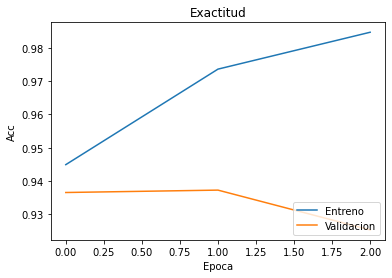

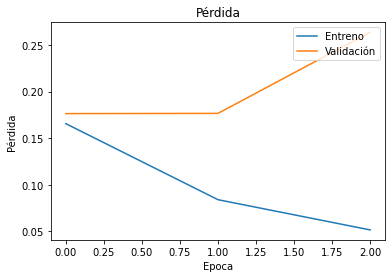

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [12]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11326  1174]
 [  839 11661]]
Exactitud:  0.91948002576828


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [13]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10320  2180]
 [ 1725 10775]]
Exactitud:  0.8438000082969666


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [4]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('Modelos/RNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Desempeño (exactitud): accu_v1=0.9287999868392944 , accu_v2=0.8373600244522095
Desempeño (exactitud): accu_v1=0.9015200138092041 , accu_v2=0.8084800243377686
Desempeño (exactitud): accu_v1=0.9490399956703186 , accu_v2=0.8402799963951111
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
| 0.9939 | 0.9288 | 0.8374 |
| 0.969  | 0.9015 | 0.8085 |
| 0.9989 | 0.949  | 0.8403 |
+--------+--------+--------+


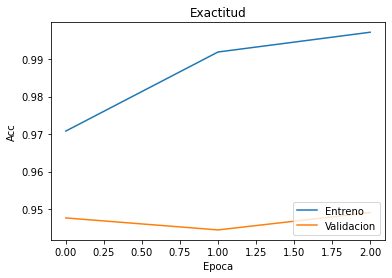

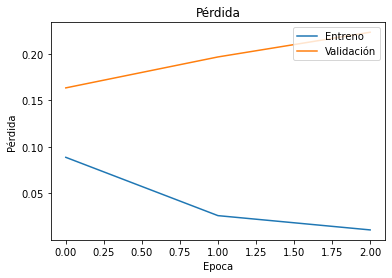

In [11]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [12]:
# B-RNN LSTM
model_rnn = load_model('Modelos/RNN_part=3.h5')

model_rnn.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [22]:
Y_predt = model_rnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_rnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[12202   298]
 [  668 11832]]
Exactitud:  0.961359977722168


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [23]:
Y_predv = model_rnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_rnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11161  1339]
 [ 2727  9773]]
Exactitud:  0.8373600244522095


**Conclusiones**

Se evidencia una diferencia entre el desempeño y parámetros de las dos redes (bidireccional - unidireccional). Alguna de ellas son:

* Parámetros:

En la red unidireccional, las capas de LSTM (primer y segundo), tienen: 49,408 y 33,024 respectivamente. Adicionalmente, tiene en total 2,642,497 de parámetros (todos entrenables). En la red bidireccional, las capas de LSTM (primer y segunda), tienen: 98,816 y 98,816 respectivamente. En total, la red bidireccional tiene 2,757,761.

* Desempeño:

En perspectiva, intuitivamente se pensaría que entre más parámetros mejor desempeño tendrá la red neuronal. Sin embargo, al revisar las siguientes tablas de desempeño en la doble validación:

    - Unidireccional LSTM

Exac_E | Exac_V | Exac_P
--------|---------|-------
0.9939 | 0.9288 | 0.8374
0.969  | 0.9015 | 0.8085
0.9989 | 0.949  | 0.8403

    - Bidireciconal LSTM

Exac_E | Exac_V | Exac_P
--------|--------|--------
0.9824 | 0.8566 | 0.8438
0.9926 | 0.8998 | 0.8425
0.9903 | 0.9252 | 0.8392

Se evidencia que tenemos un mejor desemepeño en la red neuronal unidireccional, de forma que resulta contraintuitivo.


* Tiempo de ejecución:

En cuanto al tiempo de ejecución se observa que el modelo unidireccional tiene mejor eficiencia, dado que el tiempo de ejecución es menor entre la red unidireccional en contraste con la red bidireccional.


## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

---

#### Respuesta

Realizaremos, varios modelos donde iniciaremos con diferentes arquitecturas con **Optuna**. Luego, en caso de que no tengamos un modelo eficiente aún, usaremos una busqueda por medio de Tensorboard. Donde correremos cerca de 130 modelos diferentes, cada uno con un ajuste de hiperpárametros diferentes. Estos últimos, serán con una red unidireccional.

De esta menera, iniciaremos con [Optuna: A Next-generation Hyperparameter Optimization Framework](https://arxiv.org/pdf/1907.10902.pdf). Donde, definiremos los metodos:

```python
create_model()     # Método para crear los espacios de busqueda que definiran los modelos.
create_optimizer() # Método para crear el espacio de busqueda del optimizador que se usará en cada arquitectura.
trainer()          # Método para entrar el modelo con base en la arquitectura seleccionada y con el optimizador seleccionado.
objetive()         # Método para determinar el objetivo. Por defecto, Optuna minimiza, en este caso lo usaremos para máximizar.
run_study()        # Método para correr el estudio y asignarle un nombre en la memoria de la maquina, por si se requiere volver a correrlo.
```

Iniciaremos definiendo el inicializador:

In [6]:
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

Ahora, definiremos el método para crear el modelo

In [7]:
def create_model(trial):
    
    # Limpiando la sesión
    keras.backend.clear_session()
    
    # Creando modelo Secuencia
    model = Sequential(name = 'Optuna_BRNN')
    
    # Input con secuencias de enteros con longitud variable 
    model.add(keras.Input(shape=(None,), dtype="int32"))

    # Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
    model.add(layers.Embedding(max_features, 128))
      
    # num of hidden layer
    n_layers = trial.suggest_int('n_layers', 1, 3)
       
    for i in range(n_layers):
              
        # Número de unidades
        num_hidden_one = trial.suggest_int(f"layer_Bidirectional_{i}_n_units", 4, 128, log=True)
        
        # Añadimos i unidad LSTM bidireccional con retorno de secuencia
        model.add(layers.Bidirectional(layers.LSTM(num_hidden_one, return_sequences=True)))
              
    # Número de unidades
    num_hidden_two = trial.suggest_int("layer_Bidirectional_n_units", 4, 128, log=True)
        
    # Añadimos i unidad LSTM bidireccional sin retorno de secuencia
    model.add(layers.Bidirectional(layers.LSTM(num_hidden_two)))
    
    for k in range(n_layers):
        
        # Número de unidades
        num_hidden = trial.suggest_int(f'layer_Dense_{k}_n_units', 4, 128, log=True)
        
        # Activation function
        activation_selected = trial.suggest_categorical(f"layer_Dense_{k}_activation", ["selu", "sigmoid", "tanh"])
        
        # Creación de las capas
        model.add(layers.Dense(num_hidden, activation=activation_selected, kernel_initializer=initnorm, bias_initializer='zeros'))
    

    # Añadimos un clasificador binario en la salida
    model.add(layers.Dense(1, activation="sigmoid"))
    
    
    return model

Con esto. Crearemos, un método que crea los espacios de busqueda del optimizador.

In [8]:
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        kwargs["beta_1"] = trial.suggest_loguniform('beta_1', 0.0001, 0.9)
        kwargs["beta_2"] = trial.suggest_loguniform('beta_2', 0.0001, 0.9)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

Ahora, crearemos el método que convoca a los dos métodos anteriores. Donde, además se mantendrá la doble validación.

In [9]:
def trainer(trial):

    # Inicializamos la tabla donde guardamos los resultados
    x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Optimizer"])

    # Inicializamos el error 
    err_p = 999

    for i in range(0,3,1):
        r = i^3
        CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
        
        #epocas = trial.suggest_categorical('epocas', [3, 4])
        epocas = 3

        # Definimos la arquitectura de la red
        model = create_model(trial)
        
        # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
        optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
        #optimizer = create_optimizer(trial)
        
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Ajustamos el modelo
        history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=0, shuffle=False)

        # Calculamos las metricas
        train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
        valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
        test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)

        # Guardamos las métricas de desempeño
        accu_e = train_metrics[1]
        loss_e = train_metrics[0]
        accu_v = valid_metrics[1]
        loss_v = valid_metrics[0]
        accu_p = test_metrics[1]
        loss_p = test_metrics[0]

        if (loss_p < err_p):
            pathr =('Modelos/Optuna_BRNN_part='+str(r)+'.tf')
            model.save(pathr) 
            err_p = loss_p

        # Imprimimos el desempeño para cada repetición
        print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p)  + ' , Optimizer=' + str(optimizer.get_config()["name"]))

        x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), optimizer.get_config()["name"]])

    print(x)
    return model, CE_x, CE_y, CV_x, CV_y, x_val, y_val

Se definirá, ahora el objetivo. En este caso, se definirá como máximizar la exactitud de las tres conjuntos de datos.

In [10]:
def objective(trial):

    model, CE_x, CE_y, CV_x, CV_y, x_val, y_val = trainer(trial)
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    
    evaluate = (train_metrics[1] + valid_metrics[1] + test_metrics[1]) / 3
    
    return evaluate

Y finalmente, se crea un método para correr un estudio. De manera, que tendríamos una función que nos indique el mejor modelo de acuerdo al espacio de busqueda.

In [11]:
def run_study(name):
    study = optuna.create_study(direction="maximize", 
                                study_name = f'Optuna_BRNN_{name}',
                               pruner=optuna.pruners.MedianPruner(n_startup_trials=5, 
                                                             n_warmup_steps=30, 
                                                             interval_steps=10))
    study.optimize(objective, n_trials=10, n_jobs = -1)#, callbacks=[tensorboard_callback])
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        
    #return study, pruned_trials, complete_trials, trial

Correremos, de esta manera el primer intento para optimizar el modelo. Reccordemos, que el proceso de **Optuna** se corre en paralelo, razón por la cual aparecerán impresiones irregulares en el notebook, de la siguiente manera:

In [13]:
#study, pruned_trials, complete_trials, trial = run_study(name = 'try_one')
run_study(name = 'try_one')

[I 2020-10-08 08:12:27,187] A new study created in memory with name: Optuna_BRNN_try_one


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.5151200294494629 , accu_v2=0.5199199914932251 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.5031200051307678 , accu_v2=0.5 , Optimizer=RMSprop
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.4968799948692322 , accu_v2=0.5 , Optimizer=RMSprop
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.5031200051307678 , accu_v2=0.5 , Optimizer=SGD
Desempeño (exactitud): accu_v1=0.5059999823570251 , accu_v2=0.5108799934387207 , Optimizer=Adam
Desempeño (exactitud): accu_v1=0.50135

[I 2020-10-08 21:04:57,339] Trial 0 finished with value: 0.5726799964904785 and parameters: {'epocas': 3, 'n_layers': 1, 'layer_Bidirectional_0_n_units': 93, 'layer_Bidirectional_n_units': 14, 'layer_Dense_0_n_units': 14, 'layer_Dense_0_activation': 'selu', 'optimizer': 'Adam', 'adam_learning_rate': 0.07400761315777321, 'beta_1': 0.0009401919131846431, 'beta_2': 0.1658150779773345}. Best is trial 0 with value: 0.5726799964904785.


INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=2.tf\assets
Desempeño (exactitud): accu_v1=0.5013599991798401 , accu_v2=0.5 , Optimizer=SGD
Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=RMSprop
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.4969 | 0.5031 |  0.5   |  RMSprop  |
| 0.4986 | 0.5014 |  0.5   |  RMSprop  |
| 0.5081 | 0.4919 |  0.5   |  RMSprop  |
+--------+--------+--------+-----------+
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.8739200234413147 , accu_v2=0.8668000102043152 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=1.tf\assets
Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=RMSprop
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.5031 | 0.4969 |  0.5   |

[I 2020-10-09 02:08:57,417] Trial 3 finished with value: 0.5 and parameters: {'epocas': 4, 'n_layers': 5, 'layer_Bidirectional_0_n_units': 12, 'layer_Bidirectional_1_n_units': 8, 'layer_Bidirectional_2_n_units': 39, 'layer_Bidirectional_3_n_units': 4, 'layer_Bidirectional_4_n_units': 7, 'layer_Bidirectional_n_units': 6, 'layer_Dense_0_n_units': 69, 'layer_Dense_0_activation': 'sigmoid', 'layer_Dense_1_n_units': 31, 'layer_Dense_1_activation': 'sigmoid', 'layer_Dense_2_n_units': 48, 'layer_Dense_2_activation': 'sigmoid', 'layer_Dense_3_n_units': 57, 'layer_Dense_3_activation': 'selu', 'layer_Dense_4_n_units': 6, 'layer_Dense_4_activation': 'sigmoid', 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 8.793241360091882e-05, 'rmsprop_decay': 0.9756763417067494, 'rmsprop_momentum': 0.0005769229303381571}. Best is trial 0 with value: 0.5726799964904785.
[I 2020-10-09 02:35:19,009] Trial 1 finished with value: 0.5 and parameters: {'epocas': 3, 'n_layers': 2, 'layer_Bidirectional_0_n_units': 4,

Desempeño (exactitud): accu_v1=0.8201599717140198 , accu_v2=0.818120002746582 , Optimizer=Adam
Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=SGD
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.4969 | 0.5031 |  0.5   |    SGD    |
| 0.4986 | 0.5014 |  0.5   |    SGD    |
| 0.5081 | 0.4919 |  0.5   |    SGD    |
+--------+--------+--------+-----------+
Desempeño (exactitud): accu_v1=0.8433600068092346 , accu_v2=0.836080014705658 , Optimizer=Adam
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.929  | 0.8739 | 0.8668 |    Adam   |
| 0.8759 | 0.8202 | 0.8181 |    Adam   |
| 0.9022 | 0.8434 | 0.8361 |    Adam   |
+--------+--------+--------+-----------+


[I 2020-10-09 07:48:55,640] Trial 4 finished with value: 0.86053333679835 and parameters: {'epocas': 4, 'n_layers': 3, 'layer_Bidirectional_0_n_units': 6, 'layer_Bidirectional_1_n_units': 9, 'layer_Bidirectional_2_n_units': 6, 'layer_Bidirectional_n_units': 31, 'layer_Dense_0_n_units': 20, 'layer_Dense_0_activation': 'selu', 'layer_Dense_1_n_units': 59, 'layer_Dense_1_activation': 'selu', 'layer_Dense_2_n_units': 22, 'layer_Dense_2_activation': 'selu', 'optimizer': 'Adam', 'adam_learning_rate': 0.003171240569223633, 'beta_1': 0.0007933437848716296, 'beta_2': 0.0007493563783408658}. Best is trial 4 with value: 0.86053333679835.
[I 2020-10-09 08:35:17,774] Trial 2 finished with value: 0.5 and parameters: {'epocas': 4, 'n_layers': 3, 'layer_Bidirectional_0_n_units': 25, 'layer_Bidirectional_1_n_units': 4, 'layer_Bidirectional_2_n_units': 108, 'layer_Bidirectional_n_units': 26, 'layer_Dense_0_n_units': 44, 'layer_Dense_0_activation': 'sigmoid', 'layer_Dense_1_n_units': 112, 'layer_Dense_1_

INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.4968799948692322 , accu_v2=0.5 , Optimizer=RMSprop
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.5031200051307678 , accu_v2=0.5 , Optimizer=SGD
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=2.tf\assets
Desempeño (exactitud): accu_v1=0.5013599991798401 , accu_v2=0.5 , Optimizer=RMSprop
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.4968799948692322 , accu_v2=0.5 , Optimizer=SGD
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.4968799948692322 , accu_v2=0.5 , Optimizer=SGD
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=2.tf\assets
Desempeño (exactitud): accu_v1=0.5013599991798401 , accu_v2=0.5 , Optimizer=SGD
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=1.tf\assets
Desempeñ

[I 2020-10-10 11:38:44,449] Trial 5 finished with value: 0.5 and parameters: {'epocas': 3, 'n_layers': 2, 'layer_Bidirectional_0_n_units': 67, 'layer_Bidirectional_1_n_units': 49, 'layer_Bidirectional_n_units': 15, 'layer_Dense_0_n_units': 26, 'layer_Dense_0_activation': 'sigmoid', 'layer_Dense_1_n_units': 96, 'layer_Dense_1_activation': 'sigmoid', 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 4.162124358318685e-05, 'rmsprop_decay': 0.8871701710082098, 'rmsprop_momentum': 5.94786396448213e-05}. Best is trial 4 with value: 0.86053333679835.


Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=SGD
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.4969 | 0.5031 |  0.5   |    SGD    |
| 0.4986 | 0.5014 |  0.5   |    SGD    |
| 0.5081 | 0.4919 |  0.5   |    SGD    |
+--------+--------+--------+-----------+
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=2.tf\assets
Desempeño (exactitud): accu_v1=0.5013599991798401 , accu_v2=0.5 , Optimizer=SGD
Desempeño (exactitud): accu_v1=0.5013599991798401 , accu_v2=0.5 , Optimizer=SGD


[I 2020-10-10 16:31:40,270] Trial 6 finished with value: 0.5 and parameters: {'epocas': 4, 'n_layers': 4, 'layer_Bidirectional_0_n_units': 5, 'layer_Bidirectional_1_n_units': 19, 'layer_Bidirectional_2_n_units': 4, 'layer_Bidirectional_3_n_units': 60, 'layer_Bidirectional_n_units': 44, 'layer_Dense_0_n_units': 16, 'layer_Dense_0_activation': 'tanh', 'layer_Dense_1_n_units': 12, 'layer_Dense_1_activation': 'selu', 'layer_Dense_2_n_units': 18, 'layer_Dense_2_activation': 'sigmoid', 'layer_Dense_3_n_units': 73, 'layer_Dense_3_activation': 'sigmoid', 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006100181428735928, 'sgd_opt_momentum': 6.296295261266305e-05}. Best is trial 4 with value: 0.86053333679835.


Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=SGD
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.5031 | 0.4969 |  0.5   |    SGD    |
| 0.4986 | 0.5014 |  0.5   |    SGD    |
| 0.5081 | 0.4919 |  0.5   |    SGD    |
+--------+--------+--------+-----------+
Desempeño (exactitud): accu_v1=0.49191999435424805 , accu_v2=0.5 , Optimizer=SGD
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.5031 | 0.4969 |  0.5   |    SGD    |
| 0.4986 | 0.5014 |  0.5   |    SGD    |
| 0.5081 | 0.4919 |  0.5   |    SGD    |
+--------+--------+--------+-----------+
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.8626400232315063 , accu_v2=0.8659999966621399 , Optimizer=Adam


[I 2020-10-11 06:33:42,576] Trial 8 finished with value: 0.5 and parameters: {'epocas': 4, 'n_layers': 4, 'layer_Bidirectional_0_n_units': 63, 'layer_Bidirectional_1_n_units': 9, 'layer_Bidirectional_2_n_units': 56, 'layer_Bidirectional_3_n_units': 19, 'layer_Bidirectional_n_units': 5, 'layer_Dense_0_n_units': 6, 'layer_Dense_0_activation': 'sigmoid', 'layer_Dense_1_n_units': 15, 'layer_Dense_1_activation': 'tanh', 'layer_Dense_2_n_units': 6, 'layer_Dense_2_activation': 'sigmoid', 'layer_Dense_3_n_units': 18, 'layer_Dense_3_activation': 'selu', 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0026018572708289313, 'sgd_opt_momentum': 0.0009679820533823926}. Best is trial 4 with value: 0.86053333679835.
[I 2020-10-11 07:10:28,515] Trial 7 finished with value: 0.5 and parameters: {'epocas': 4, 'n_layers': 4, 'layer_Bidirectional_0_n_units': 67, 'layer_Bidirectional_1_n_units': 13, 'layer_Bidirectional_2_n_units': 25, 'layer_Bidirectional_3_n_units': 7, 'layer_Bidirectional_n_units': 113, 'l

Desempeño (exactitud): accu_v1=0.8464800119400024 , accu_v2=0.8448399901390076 , Optimizer=Adam
Desempeño (exactitud): accu_v1=0.8566399812698364 , accu_v2=0.8557199835777283 , Optimizer=Adam
+--------+--------+--------+-----------+
| Exac_E | Exac_V | Exac_P | Optimizer |
+--------+--------+--------+-----------+
| 0.8997 | 0.8626 | 0.866  |    Adam   |
| 0.8782 | 0.8465 | 0.8448 |    Adam   |
| 0.8859 | 0.8566 | 0.8557 |    Adam   |
+--------+--------+--------+-----------+


[I 2020-10-11 19:41:19,999] Trial 9 finished with value: 0.8660933176676432 and parameters: {'epocas': 3, 'n_layers': 5, 'layer_Bidirectional_0_n_units': 26, 'layer_Bidirectional_1_n_units': 84, 'layer_Bidirectional_2_n_units': 7, 'layer_Bidirectional_3_n_units': 95, 'layer_Bidirectional_4_n_units': 5, 'layer_Bidirectional_n_units': 82, 'layer_Dense_0_n_units': 34, 'layer_Dense_0_activation': 'selu', 'layer_Dense_1_n_units': 13, 'layer_Dense_1_activation': 'selu', 'layer_Dense_2_n_units': 23, 'layer_Dense_2_activation': 'tanh', 'layer_Dense_3_n_units': 9, 'layer_Dense_3_activation': 'tanh', 'layer_Dense_4_n_units': 43, 'layer_Dense_4_activation': 'selu', 'optimizer': 'Adam', 'adam_learning_rate': 0.0004890727576877038, 'beta_1': 0.001357468105570824, 'beta_2': 0.0001985633318658259}. Best is trial 9 with value: 0.8660933176676432.


KeyboardInterrupt: 

**Optuna**

Vemos que no parece mejorar la precisión de los modelos, así mismo, tampoco parece mejorar cambiando en distintas arquitecturas. Esto puede deberse al número de *trials* o al consumo de memoria que se requiere para correr este proceso. Es necesario para otras oportunidades mejorar el hardware pues, con el actual este problema puede demorarse más de una semana. **Los resultados en la celda superior lo evidencian. Pues, fueron corridos durante 5 días seguidos y esos fueron los resultados**

De manera, que cambiaremos la estructura y estrategía para verificar si el tiempo de ejecución continua siendo tardio despues de los ajustes.

In [ ]:
run_study(name = 'try_one')

[I 2020-10-15 10:59:55,642] A new study created in memory with name: Optuna_BRNN_try_one


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.8503999710083008 , accu_v2=0.8434000015258789 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.8555200099945068 , accu_v2=0.8406400084495544 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.83024001121521 , accu_v2=0.8173999786376953 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=3.tf\assets
Desempeño (exactitud): accu_v1=0.8407999873161316 , accu_v2=0.8288000226020813 , Optimizer=Adam
INFO:tensorflow:Assets written to: Modelos/Optuna_BRNN_part=2.tf\assets
Desempeño (exactitud): a

Efectivamente, los resultados no mejoraron y el modelo con **Optuna** continua teniendo un alto consumo de memoria. 


---

**Tensorboard**


Ahora usaremos **Tensorboard** para poder medir un ajuste. Con esto, esperamos cubrir de manera diferente el ajuste de hiperparámetros que no pudo ser resuleto con **Optuna**. De la manera en que iniciaremos revisando la lista de experimentos:

In [1]:
!tensorboard dev list

https://tensorboard.dev/experiment/X9KaN3nYQW6HMig5dPAr9g/

2020-10-18 20:21:04.742209: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-10-18 20:21:04.744703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Total: 3 experiment(s)



	Name                 Semana 8: Red Neuronal Recurrente LSTM Bidireccional Actividad
	Description          Resultados de entrenamiento desde https://sergiomora03.github.io/deep-learning-intermediate/
	Id                   X9KaN3nYQW6HMig5dPAr9g
	Created              2020-10-17 02:06:19
	Updated              2020-10-17 02:06:42
	Runs                 4
	Tags                 3
	Scalars              56
	Tensor bytes         0
	Binary object bytes  892284
https://tensorboard.dev/experiment/mQfPPEzARJeQwocxAA8gRQ/
	Name                 Semana 5: Redes Profundas con Keras
	Description          Resultados de entrenamiento desde https://sergiomora03.github.io/deep-learning-intermediate/
	Id                   mQfPPEzARJeQwocxAA8gRQ
	Created              2020-09-20 17:23:54
	Updated              2020-09-20 17:25:01
	Runs                 145
	Tags                 7
	Scalars              19248
	Tensor bytes         12470
	Binary object bytes  11207445
https://tensorboard.dev/experiment/nAjDT33WRxC

In [13]:
!tensorboard dev delete --experiment_id 59W98WDsRn2xV483GcjX9w

Deleted experiment 59W98WDsRn2xV483GcjX9w.


Después de borrar el experimento (que nos servía). Crearemos el experimento nuevamente en Tensorboard.dev De manera que se tendrá un link al que acceder para ver los resultados de la exactitud para las distintas combinaciones en los hiperparámetros.

In [24]:
!tensorboard dev upload --logdir ./logs/ \
  --name "Semana 8: Red Neuronal Recurrente LSTM Bidireccional Actividad" \
  --description "Resultados de entrenamiento semana 8 desde https://sergiomora03.github.io/deep-learning-intermediate/" \
  --one_shot

Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/H1SV5hl6TzWKNvu9lPXxOg/


Done. View your TensorBoard at https://tensorboard.dev/experiment/H1SV5hl6TzWKNvu9lPXxOg/


2020-10-19 00:17:45.744852: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-10-19 00:17:45.745233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "c:\users\samora\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\samora\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samora\Anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "c:\users\samora\anaconda3\lib\site-packages\tensorboard\main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "c:\users\samora\anaconda3\lib\site-packages\absl\app.py", line 300, in run
    _run_main(main, args)
  File "c:\users\samora\anaconda3\lib\

In [17]:
!tensorboard dev list

https://tensorboard.dev/experiment/X9KaN3nYQW6HMig5dPAr9g/


Total: 3 experiment(s)

	Name                 Semana 8: Red Neuronal Recurrente LSTM Bidireccional Actividad


	Description          Resultados de entrenamiento desde https://sergiomora03.github.io/deep-learning-intermediate/
	Id                   X9KaN3nYQW6HMig5dPAr9g
	Created              2020-10-17 02:06:19 (55 seconds ago)
	Updated              2020-10-17 02:06:42 (32 seconds ago)
	Runs                 4
	Tags                 3
	Scalars              56
	Tensor bytes         0
	Binary object bytes  892284
https://tensorboard.dev/experiment/mQfPPEzARJeQwocxAA8gRQ/
	Name                 Semana 5: Redes Profundas con Keras
	Description          Resultados de entrenamiento desde https://sergiomora03.github.io/deep-learning-intermediate/
	Id                   mQfPPEzARJeQwocxAA8gRQ
	Created              2020-09-20 17:23:54
	Updated              2020-09-20 17:25:01
	Runs                 145
	Tags                 7
	Scalars              19248
	Tensor bytes         12470
	Binary object bytes  11207445
https://tensorboard.dev/experiment/nAjDT33WRxCLXNQkrD9LSQ/
	Name                 Semana 5: Redes 

Es necesario definir un diccionario con los hiperparámetros a correr y combinar. Estos serán los siguientes:

* Número de unidades en la primera capa.
* Número de unidades en la segunda capa.
* Número de unidades en la capa densa.
* Función de activación de la capa densa.
* Optimizador que se usará.

In [22]:
# Dicccionario de hiperparametros
HP_NUM_UNITS_LSTM = hp.HParam('num_units_LSTM', hp.Discrete([50, 100, 200, 300]))
HP_NUM_UNITS_LSTM_2 = hp.HParam('num_units_LSTM_2', hp.Discrete([25, 50, 100]))
HP_NUM_UNITS_DENSE = hp.HParam('num_units_Dense', hp.Discrete([16, 32, 64, 128]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['selu','sigmoid','tanh']))
#HP_INIT = hp.HParam('init', hp.Discrete(['RandomNormal']))
#HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_ACCURACY = 'accuracy'

Ahora, crearemos un directorio de hiperparámetros, en donde se puede evidenciar el registro de cada uno de los modelos ejecutados. Esto será útil en caso de que no cargue el **Tensorboard** o se desconecte el mismo con **Tensorboard.dev** Y podrá evidenciarse cada una de las corridas.

In [23]:
# Creando directorio de hiperparametros
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS_LSTM, HP_NUM_UNITS_DENSE, HP_OPTIMIZER, HP_ACTIVATION, HP_NUM_UNITS_LSTM_2],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

Finalmente, crearemos un metodo que haga la división para los tres conjuntos diferentes que consumira el modelo para ser entrenado, también que cree la arquitectura y que guarde los registros de los modelos corridos.

In [24]:
def train_test_model(run_dir, hparams):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(None,), dtype="int32"),
        tf.keras.layers.Embedding(max_features, 
                         128),
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS_LSTM], 
                    return_sequences=True),
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS_LSTM_2]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS_DENSE], 
                     activation=hparams[HP_ACTIVATION], 
                     kernel_initializer=initnorm, 
                     bias_initializer='zeros'),
        layers.Dense(1, activation="sigmoid")        
  ])
    modelo = "Exec="+"".join(datetime.datetime.now().strftime('%f'))
    # Callbacks
    fBestModel = 'best_model.h5'
    early_stop = EarlyStopping(monitor='accuracy', patience=20, verbose=1) 
    best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

    model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=['accuracy'])
    
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = 1)
    
    model.fit(x=CE_x, y=CE_y, validation_data=(CV_x, CV_y), 
              epochs=3, 
              verbose = 0,
              callbacks=[tf.keras.callbacks.TensorBoard(run_dir), 
                         hp.KerasCallback(run_dir, hparams), 
                         #PlotLossesKeras(), 
                         #early_stop,
                         best_model])
    _, accuracy = model.evaluate(CV_x, CV_y, verbose = 0)

    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)


    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]

    # Guardamos el modelo
    pathr =('Modelos/Taller_8/modelo_'+modelo+'.h5')
    model.save(pathr) 

    # Valores de exactitud
    x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Model"])#, "Arquitectura"])
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), pathr])#, json.dumps({h.name: hparams[h] for h in hparams})])
    print("\n", x)


    #Y_pred = model.predict(X)
    #Y_preds = (Y_pred > 0.5)

    #confusion_matrix(Y.T, Y_preds)

    return accuracy

Sion pensar en más, se define el método de `run()` para ejecutar el loop que recorrerá el espacio que determine la arquitectura con los hiperparámetros y los registrará en **Tensorboard.dev** de la siguiente manera:

In [25]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(run_dir, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

Y correremos el modelo. Ahora con este loop se recorrera comos e había mencionado anteriormente cada una de las arquitecturas que se definiran dentros del espacio de busqueda con **Tensorboard**. De la siguiente manera:

In [ ]:
session_num = 0

for num_units_LSTM in HP_NUM_UNITS_LSTM.domain.values:
    for num_units_LSTM_2 in HP_NUM_UNITS_LSTM_2.domain.values:
        for num_units_Dense in HP_NUM_UNITS_DENSE.domain.values:
            for activacion in HP_ACTIVATION.domain.values:
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                      HP_NUM_UNITS_LSTM: num_units_LSTM,
                      HP_NUM_UNITS_LSTM_2: num_units_LSTM_2,
                      HP_NUM_UNITS_DENSE: num_units_Dense,
                      HP_ACTIVATION: activacion,
                      HP_OPTIMIZER: optimizer,
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 16, 'activation': 'selu', 'optimizer': 'adam'}
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9892 | 0.8521 | 0.8393 | Modelos/Taller_8/modelo_Exec=123203.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-1
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 16, 'activation': 'selu', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9639 | 0.8734 | 0.8623 | Modelos/Taller_8/modelo_Exec=745642.h5 |
+--------+---

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-12
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.981  | 0.864  | 0.8467 | Modelos/Taller_8/modelo_Exec=319865.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-13
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 32, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.951  | 0.8677 | 0.8529 | Modelos/Taller_8/modelo_Exec=377431.h5 |
+------

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-24
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 64, 'activation': 'tanh', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9868 | 0.8514 | 0.846  | Modelos/Taller_8/modelo_Exec=701655.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-25
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9344 | 0.8467 | 0.8285 | Modelos/Taller_8/modelo_Exec=010100.h5 |
+--------+---


 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9793 | 0.8578 | 0.8448 | Modelos/Taller_8/modelo_Exec=130881.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-49
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 32, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9574 | 0.8783 | 0.8664 | Modelos/Taller_8/modelo_Exec=699726.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-50
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 32, 'activation': 'sigmoid', 'optimizer': 'sgd'}

 +-----

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-61
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 64, 'activation': 'tanh', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9636 | 0.8731 | 0.857  | Modelos/Taller_8/modelo_Exec=755183.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-62
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 64, 'activation': 'tanh', 'optimizer': 'sgd'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.5081 | 0.4919 |  0.5   | Modelos/Taller_8/modelo_Exec=581715.h5 |
+--------+----


 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9601 | 0.8746 | 0.8612 | Modelos/Taller_8/modelo_Exec=296605.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-86
{'num_units_LSTM': 50, 'num_units_LSTM_2': 100, 'num_units_Dense': 32, 'activation': 'sigmoid', 'optimizer': 'sgd'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.5081 | 0.4919 |  0.5   | Modelos/Taller_8/modelo_Exec=186526.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-87
{'num_units_LSTM': 50, 'num_units_LSTM_2': 100, 'num_units_Dense': 32, 'activation': 'tanh', 'optimizer': 'adam'}

 +--------+

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-98
{'num_units_LSTM': 50, 'num_units_LSTM_2': 100, 'num_units_Dense': 64, 'activation': 'tanh', 'optimizer': 'sgd'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.5081 | 0.4919 |  0.5   | Modelos/Taller_8/modelo_Exec=903652.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-99
{'num_units_LSTM': 50, 'num_units_LSTM_2': 100, 'num_units_Dense': 128, 'activation': 'selu', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9777 | 0.8473 | 0.833  | Modelos/Taller_8/modelo_Exec=759096.h5 |
+--------+----


 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.4919 | 0.5081 |  0.5   | Modelos/Taller_8/modelo_Exec=876640.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-123
{'num_units_LSTM': 100, 'num_units_LSTM_2': 25, 'num_units_Dense': 32, 'activation': 'tanh', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9807 | 0.8575 | 0.841  | Modelos/Taller_8/modelo_Exec=666118.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-124
{'num_units_LSTM': 100, 'num_units_LSTM_2': 25, 'num_units_Dense': 32, 'activation': 'tanh', 'optimizer': 'rmsprop'}

 +------

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-135
{'num_units_LSTM': 100, 'num_units_LSTM_2': 25, 'num_units_Dense': 128, 'activation': 'selu', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9766 | 0.8482 | 0.8341 | Modelos/Taller_8/modelo_Exec=177111.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-136
{'num_units_LSTM': 100, 'num_units_LSTM_2': 25, 'num_units_Dense': 128, 'activation': 'selu', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9561 | 0.8611 | 0.8523 | Modelos/Taller_8/modelo_Exec=255939.h5 |
+------


 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9803 | 0.8541 | 0.8403 | Modelos/Taller_8/modelo_Exec=613155.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-160
{'num_units_LSTM': 100, 'num_units_LSTM_2': 50, 'num_units_Dense': 32, 'activation': 'tanh', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9591 | 0.8661 | 0.8576 | Modelos/Taller_8/modelo_Exec=527173.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-161
{'num_units_LSTM': 100, 'num_units_LSTM_2': 50, 'num_units_Dense': 32, 'activation': 'tanh', 'optimizer': 'sgd'}

 +-------

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-172
{'num_units_LSTM': 100, 'num_units_LSTM_2': 50, 'num_units_Dense': 128, 'activation': 'selu', 'optimizer': 'rmsprop'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9051 | 0.8302 | 0.8094 | Modelos/Taller_8/modelo_Exec=996345.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-173
{'num_units_LSTM': 100, 'num_units_LSTM_2': 50, 'num_units_Dense': 128, 'activation': 'selu', 'optimizer': 'sgd'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.5081 | 0.4919 |  0.5   | Modelos/Taller_8/modelo_Exec=909606.h5 |
+-------

Después de correr cerca de 130 modelos, evidenciamos cierta dificultad en la combinación de hiperparámetros y adicionalmente, del tiempo de ejecución. No obstante, tenemos que realizarle unso ajustes en la selección del optimizador. Tenemos, ahora el siguiente método para registrar los valores de cada una de las arquitrecturas que crea de acuerdo al ajuste de hiperparámetros seleccionados en **Tensorboard** de la siguiente manera:

In [ ]:
session_num = 0

for num_units_LSTM in HP_NUM_UNITS_LSTM.domain.values:
    for num_units_LSTM_2 in HP_NUM_UNITS_LSTM_2.domain.values:
        for num_units_Dense in HP_NUM_UNITS_DENSE.domain.values:
            for activacion in HP_ACTIVATION.domain.values:
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                      HP_NUM_UNITS_LSTM: num_units_LSTM,
                      HP_NUM_UNITS_LSTM_2: num_units_LSTM_2,
                      HP_NUM_UNITS_DENSE: num_units_Dense,
                      HP_ACTIVATION: activacion,
                      HP_OPTIMIZER: optimizer,
                    }
                    run_name = f'run-{session_num}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1
                    break

--- Starting trial: run-0
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 16, 'activation': 'selu', 'optimizer': 'adam'}
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.989  | 0.8574 | 0.8432 | Modelos/Taller_8/modelo_Exec=836924.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-1
{'num_units_LSTM': 50, 'num_units_LSTM_2': 25, 'num_units_Dense': 16, 'activation': 'sigmoid', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9595 | 0.8501 | 0.8424 | Modelos/Taller_8/modelo_Exec=234852.h5 |
+--------+---

+--------+--------+--------+----------------------------------------+
--- Starting trial: run-12
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 16, 'activation': 'selu', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9902 | 0.8576 | 0.8434 | Modelos/Taller_8/modelo_Exec=106639.h5 |
+--------+--------+--------+----------------------------------------+
--- Starting trial: run-13
{'num_units_LSTM': 50, 'num_units_LSTM_2': 50, 'num_units_Dense': 16, 'activation': 'sigmoid', 'optimizer': 'adam'}

 +--------+--------+--------+----------------------------------------+
| Exac_E | Exac_V | Exac_P |                 Model                  |
+--------+--------+--------+----------------------------------------+
| 0.9444 | 0.8338 | 0.8229 | Modelos/Taller_8/modelo_Exec=928003.h5 |
+--------+---

In [5]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir C:/Users/samora/OneDrive\ \-\ Politécnico\ Grancolombiano/MIIA/Modelos\ Avanzados\ de\ Analísis\ de\ Datos\ II/deep\-learning\-intermediate/Activities/logs/

![Tensorboard]("./Resultados/tensorboard.png")

---

**Conclusión**

Podemos concluir, que para correr una red bidireccional con LSTM, se requiere de más memoria a la disponible en este momento. Adiconalmente, queda de aprendizaje que una red bidireccional así tenga más parámetros no será siempre la mejor solución posible. También, se concluye que la optimización con **Optuna** debería ser la más eficiente, sin embargo tuvo el peor desempeño dentro de las estrategías implementadas en este Notebook.

Pueden revisarse los logs de las corridas de **Tensorboard** en el siguiente [enlace](https://tensorboard.dev/experiment/Z3r18vsgTe2NOKgX6kktyQ/#hparams) o en el sigueinte puede revisar los logs corridos [enlace](https://github.com/sergiomora03/deep-learning-intermediate/upload/master/Activities/logs) (en caso de que este roto el link).


**Recomendaciones**

* Se hubiese podido lograr un mejor ajuuste si no se habría implementado un modelo de redes neuronales recurrentes bidireccionales, que afecten el desempeño del modelo. De manera tal, que hubieramos podido correr arquitecturas diferentes a las capas con LSTM, como por ejemplo un modelo con GRU o con CNN.

* Es pobrable que se desconecte el **Tensorboard** así que para futuros ensayos se intentará correrlo desde el local y no subirlo directamente a la nube.

* Es mucho mejor el desempeño de un modelo unidireccional que uno bidireccional para este caso. Inferimos que pueden usarse GRU, de tal manera que se mejor aún más el modelo.